In [212]:
import pandas as pd

train = pd.read_json('data/trainmodel.json')
validate = pd.read_json('data/val.json')

train['answers'] = train['answers'].apply(lambda x: x[0])
validate['answers'] = validate['answers'].apply(lambda x: x[0])

In [213]:
train.head(5)

,qId,answers,qText
0,wqr000001,Padmé Amidala,what character did natalie portman play in sta...
1,wqr000002,New York City,what state does selena gomez?
2,wqr000003,Bahamas,what country is the grand bahama island in?
3,wqr000005,Denethor II,what character did john noble play in lord of ...
4,wqr000006,Chicago Bulls,who does joakim noah play for?


In [214]:
questions = train['qText'].values
answers = train['answers'].values
questions_val = validate['qText'].values
answers_val = validate['answers'].values

questions_text = " ".join(list(questions))
answers_text = " ".join(list(answers))
questions_val_text = " ".join(list(questions_val))
answers_val_text = " ".join(list(answers_val))

full_text = "$" + questions_text + " " + answers_text + " " + questions_val_text + " " + answers_val_text + "@"

In [215]:
vocab_size = len(set(full_text))
encoder_map = {'$': 0, '@': 1}
decoder_map = {0: '$', 1: '@'}
unique_chars = set(full_text)

for i, c in enumerate(unique_chars.difference({'$', '@'}), start=2):
    encoder_map[c] = i
    decoder_map[i] = c

encode = lambda x: [encoder_map[c] for c in x]
decode = lambda x: ''.join([decoder_map[i] for i in x])


In [216]:
encode("$$$Test string@"), decode(encode("$$$Test string@"))

([0, 0, 0, 33, 28, 43, 29, 95, 43, 29, 98, 23, 88, 11, 1], '$$$Test string@')

In [217]:
import torch

torch.manual_seed(2115)
batch_size = 16
seq_len = 16
n_embed = 32
num_heads = 4


def pad_sequences(sequences, seq_len):
    padded_sequences = [[0] * (seq_len - len(seq)) + seq for seq in sequences]
    return padded_sequences


def truncate_sequences(sequences, max_len):
    truncated_sequences = [seq[:max_len] for seq in sequences]
    return truncated_sequences


def get_batches(questions, answers):
    idx = torch.randint(0, len(questions), (batch_size,))
    batch_questions = questions[idx].tolist()
    batch_answers = answers[idx].tolist()

    encoded_questions = [encode(q)[:-1] for q in batch_questions]
    encoded_answers = [encode(a)[:-1] for a in batch_answers]

    y_questions = [encode(q)[1:] for q in batch_questions]
    y_answers = [encode(a)[1:] for a in batch_answers]

    encoded_questions = truncate_sequences(encoded_questions, seq_len)
    encoded_answers = truncate_sequences(encoded_answers, seq_len)
    y_questions = truncate_sequences(y_questions, seq_len)
    y_answers = truncate_sequences(y_answers, seq_len)

    x = pad_sequences(encoded_questions, seq_len)
    y = pad_sequences(y_questions, seq_len)
    x_ans = pad_sequences(encoded_answers, seq_len)
    y_ans = pad_sequences(y_answers, seq_len)

    x, y, x_ans, y_ans = map(lambda seqs: torch.tensor(seqs), [x, y, x_ans, y_ans])

    return x, y, x_ans, y_ans


x, y, x_ans, y_ans = get_batches(questions, answers)

In [218]:
%reload_ext autoreload
%autoreload 2
from EncoderDecoder.layers.Decoder.Decoder import Decoder
from EncoderDecoder.layers.Encoder.Encoder import Encoder
import torch.nn as nn
import torch.nn.functional as F


class EncoderDecoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = Encoder(vocab_size, n_embed, num_heads, seq_len)
        self.decoder = Decoder(vocab_size, n_embed, num_heads, seq_len)

    def forward(self, prompt, response, targets=None):
        src_mask, tgt_mask = self.generate_mask(prompt, response)
        k, v = self.encoder(prompt, src_mask)
        x, loss = self.decoder(response, k, v, targets, tgt_mask)
        return x, loss

    @staticmethod
    def generate_mask(src, tgt):
        src_mask = (src != 0).unsqueeze(1)
        tgt_mask = (tgt != 0).unsqueeze(1)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def generate(self, prompt, idx, n):
        for _ in range(n):
            idx_crop = idx[:, -seq_len:]
            logits, _ = self(idx_crop, prompt)
            logits = logits[:, -1, :]
            p = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(p, num_samples=1)
            if next_token == 1 or next_token == [1]:
                return idx
            idx = torch.cat((idx, next_token), dim=1)
        return idx

In [219]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y, x_ans, y_ans = get_batches(questions, answers) if split == 'train' else get_batches(questions_val,
                                                                                                      answers_val)
            logits, loss = model(x, y, x_ans)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [220]:
m = EncoderDecoder()
x, y, x_ans, y_ans = get_batches(questions, answers)

x = x[:1]
y = y[:1]
x_ans = x_ans[:1]
y_ans = y_ans[:1]

m(x, y, x_ans)

(tensor([[-0.6594, -0.9378,  0.1747,  ...,  0.0388, -0.5088, -0.0679],
         [ 0.1900, -1.0047,  0.9578,  ...,  0.5132, -0.1564, -0.7422],
         [-0.9429, -0.6643, -0.9468,  ..., -0.8344, -0.2469, -0.2425],
         ...,
         [ 0.0938,  0.5375,  0.6104,  ...,  0.0753,  0.1832,  0.6649],
         [-0.2500, -0.2124,  0.0804,  ...,  0.4856,  0.1038, -0.4429],
         [ 0.0680, -0.4675, -0.2153,  ..., -0.4312,  0.7411, -0.2365]],
        grad_fn=<ViewBackward0>),
 tensor(4.7942, grad_fn=<NllLossBackward0>))

In [221]:
import os


def notify_end_of_cell(message="Cell execution completed!"):
    os.system(f'notify-send "Jupyter Cell Notification" "{message}"')


optimizer = torch.optim.Adam(m.parameters(), lr=0.0003)
history = []
eval_interval = 10
max_iter = 500
for iter in range(max_iter):
    if iter % eval_interval == 0:
        losses = estimate_loss(m)
        history.append((iter, losses))
        print(f'Iter {iter}, train loss: {losses["train"]:.3f}, val loss: {losses["val"]:.3f}')

    x, y, x_ans, y_ans = get_batches(questions, answers)
    logits, loss = m(x, y, x_ans)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
notify_end_of_cell()

Iter 0, train loss: 4.801, val loss: 4.800
Iter 10, train loss: 4.506, val loss: 4.526
Iter 20, train loss: 4.217, val loss: 4.238
Iter 30, train loss: 3.976, val loss: 4.024
Iter 40, train loss: 3.808, val loss: 3.877
Iter 50, train loss: 3.694, val loss: 3.743
Iter 60, train loss: 3.611, val loss: 3.651
Iter 70, train loss: 3.515, val loss: 3.590
Iter 80, train loss: 3.447, val loss: 3.516
Iter 90, train loss: 3.432, val loss: 3.474
Iter 100, train loss: 3.351, val loss: 3.424
Iter 110, train loss: 3.315, val loss: 3.356
Iter 120, train loss: 3.301, val loss: 3.336
Iter 130, train loss: 3.266, val loss: 3.315
Iter 140, train loss: 3.229, val loss: 3.304
Iter 150, train loss: 3.208, val loss: 3.266
Iter 160, train loss: 3.193, val loss: 3.255
Iter 170, train loss: 3.158, val loss: 3.204
Iter 180, train loss: 3.167, val loss: 3.211
Iter 190, train loss: 3.137, val loss: 3.198
Iter 200, train loss: 3.148, val loss: 3.191
Iter 210, train loss: 3.135, val loss: 3.185
Iter 220, train loss:

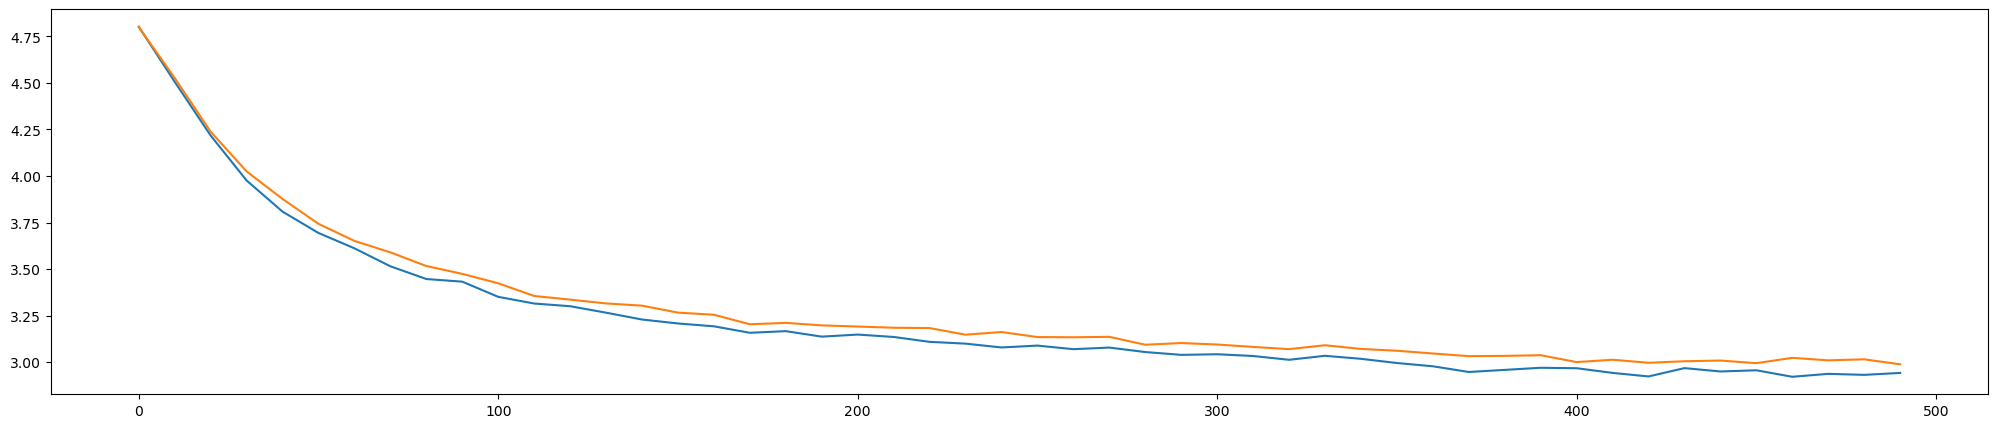

In [222]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 5))

x = [h[0] for h in history]
y = [h[1]['train'] for h in history]
y_val = [h[1]['val'] for h in history]
plt.plot(x, y, label='train')
plt.plot(x, y_val, label='val')

In [223]:
prompt = 'where is Perpignan located?'
prompt = torch.tensor(truncate_sequences([encode(prompt)], seq_len))
idx = torch.ones((1, 1), dtype=torch.long)
print(decode(m.generate(prompt, idx, 100)[0].tolist()))

@sbeenatlnnacar $Alt $iksntDoMms lator$ lcf+gIafalErTl nn NeralualireblaglbQaiT$0l 9d iea$eeeAi arAC 


In [224]:
# torch.save(m.state_dict(), './models/parallel_checkpoints_64_2.pth')